### **Time Series using Tensorflow**

In [1]:
# DL needs
import tensorflow as tf
import keras as kr

# Data needs
import pandas as pd
from sklearn.model_selection import train_test_split

# Numerical computation needs
import numpy as np

# plotting needs
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ensuring reproducibility
random_seed=42
tf.random.set_seed(random_seed)

import sys
sys.path.append('/home/rudraksha14/Desktop/RAY_RISE_ABOVE_YOURSELF/Programming/tensorflow/')

import important_functionalities as impf
import time_series_functionalities as tsf

2025-03-28 20:47:15.758437: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
### RESULTS:
baseline_results = {'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

model_1_results = {'mae': 568.06366,
 'mse': 1159591.9,
 'rmse': 1076.8435,
 'mape': 2.5265791,
 'mase': 0.9979305}

model_2_results = {'mae': 597.3115,
 'mse': 1246714.0,
 'rmse': 1116.5635,
 'mape': 2.696134,
 'mase': 1.0441062}

model_3_results = {'mae': 1272.8289,
 'mse': 5554035.5,
 'rmse': 2356.7002,
 'mape': 5.8320484,
 'mase': 2.2649276}

model_4_results = {'mae': 566.3369,
 'mse': 1167021.1,
 'rmse': 1080.2875,
 'mape': 2.5285356,
 'mase': 0.99489707}

model_5_results = {'mae': 567.6664,
 'mse': 1167780.1,
 'rmse': 1080.6388,
 'mape': 2.5524669,
 'mase': 0.9972326}

model_6_results = {'mae': 564.60266,
 'mse': 1159175.1,
 'rmse': 1076.6499,
 'mape': 2.5315979,
 'mase': 0.9918505}

model_7_results = {'mae': 584.861,
 'mse': 1223363.5,
 'rmse': 1106.0576,
 'mape': 2.6246307,
 'mase': 1.0274389}

**25. Replicating N-BEATS algorithm (Model 7)**
* N-BEATS: Neural Basis Expansion Analysis for interpretable Time Series forecasting.
* https://arxiv.org/pdf/1905.10437
* We will replicate the algorithm in figure 1 from the paper
* We are doing this because:
  * This will allow us to practice replicating a paper in TensorFlow code.
  * We will see how to use TensorFlow layer subclassing to make our own custom layers.
  * We will also get experience using the Functional API to create a custom architecuture.
  * Potentially try getting state of the ART results on our problem.

<img src='nbeats.png' width = '600'></img>

In [3]:
data = pd.read_csv('bitcoin_data.csv', parse_dates=['Date'], index_col=['Date'])
# parse the date column and tell pandas column 1 is date-time

In [4]:
# reduce the data to only have date and closing price of bit-coin
bitcoin_prices = pd.DataFrame(data["Closing Price (USD)"]).rename(columns={"Closing Price (USD)":"Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


**25.1. Building and testing the N-BEATS**

* Because the N-BEATS block layer doesn't exist in tensorflow, we have got to create it.
* To create custom layers and models in tensorflow, we can employ subclassing: https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing

In [5]:
# Create N-BEATS block custom layer

@kr.utils.register_keras_serializable(package="NBeatsBlock")
class NBeatsBlock(kr.layers.Layer):
    def __init__(self,
                 input_size:int,
                 theta_size:int,
                 horizon:int,
                 n_neurons:int,
                 n_layers:int,
                 **kwargs): # the keyword arguements takes care of all arguements for parent class
                            # eg: input_shape, trainable, name etc.
        super().__init__(**kwargs)
        
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        # Block contains stack of 4 fully connected layers each has ReLU activation
        self.hidden = [tf.keras.layers.Dense(units=n_neurons,activation='relu') for _ in range(n_layers)]

        # output of block is a thetha layer with linear activation
        self.theta_layer =tf.keras.layers.Dense(theta_size,activation='linear', name = 'theta')

    def call(self,inputs):
        x = inputs
        for layer in self.hidden:
            x = layer(x)
        theta = self.theta_layer(x) 
        # theta acts as output layer
        ### there will be two parts 
        ### forecast --> size = horizon
        ### backcast --> size = window_size
        ### total size = windows_size + horizon

        # output the backcast and forecast from theta
        backcast,forecast = theta[:,:self.input_size],theta[:,-self.horizon:]

        return backcast,forecast

In [6]:
# testing NBeatsBlock
HORIZON = 1
WINDOW_SIZE = 7

dummy_nbeats_layer = NBeatsBlock(input_size = WINDOW_SIZE,
                                 theta_size = WINDOW_SIZE+HORIZON,
                                 horizon = HORIZON,
                                 n_neurons = 128, # paper uses 512
                                 n_layers = 4, # paper uses 4 FC layers
                                 )

In [7]:
# creating dummy inputs
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE),axis = 0) # input shape must has to reflect dense layer input requirement (ndim = 2) --> (batch_size,window_size)
dummy_inputs 

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6]], dtype=int32)>

In [9]:
# passing dummy inputs  to dummy NBeatsBlock layer
backcast,forecast = dummy_nbeats_layer(dummy_inputs)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-0.29795504 -0.17953026 -0.90370333 -0.88522696  0.31510502  0.46066192
  0.47246486]
Forecast: 0.5067290663719177


**25.2. Creating a performant data pipeline using `tf.data`**

* To make our input data to load as fast as possible, we will adhere to performant data pipeline steps in `tf. data` guide: https://www.tensorflow.org/guide/data_performance
* N-BEATS works with univariate time series

In [10]:
HORIZON = 1
WINDOW_SIZE = 7

bitcoin_prices_n_beats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE,0,-1):
    bitcoin_prices_n_beats[f'Price+{WINDOW_SIZE-i+1}'] = bitcoin_prices['Price'].shift(periods=i)

bitcoin_prices_n_beats

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.654990,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.455000,NaN,NaN,NaN,NaN,NaN,NaN,123.654990
2013-10-03,108.584830,NaN,NaN,NaN,NaN,NaN,123.654990,125.455000
2013-10-04,118.674660,NaN,NaN,NaN,NaN,123.654990,125.455000,108.584830
2013-10-05,121.338660,NaN,NaN,NaN,123.654990,125.455000,108.584830,118.674660
...,...,...,...,...,...,...,...,...
2021-05-14,49764.132082,56583.849879,57107.120672,58788.209679,58102.191426,55715.546651,56573.555472,52147.821187
2021-05-15,50032.693137,57107.120672,58788.209679,58102.191426,55715.546651,56573.555472,52147.821187,49764.132082
2021-05-16,47885.625255,58788.209679,58102.191426,55715.546651,56573.555472,52147.821187,49764.132082,50032.693137


In [11]:
# make features and labels
X = bitcoin_prices_n_beats.dropna().drop('Price',axis=1)
y = bitcoin_prices_n_beats.dropna()['Price']

X

,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,
2013-10-08,123.654990,125.455000,108.584830,118.674660,121.338660,120.655330,121.795000
2013-10-09,125.455000,108.584830,118.674660,121.338660,120.655330,121.795000,123.033000
2013-10-10,108.584830,118.674660,121.338660,120.655330,121.795000,123.033000,124.049000
2013-10-11,118.674660,121.338660,120.655330,121.795000,123.033000,124.049000,125.961160
2013-10-12,121.338660,120.655330,121.795000,123.033000,124.049000,125.961160,125.279660
...,...,...,...,...,...,...,...
2021-05-14,56583.849879,57107.120672,58788.209679,58102.191426,55715.546651,56573.555472,52147.821187
2021-05-15,57107.120672,58788.209679,58102.191426,55715.546651,56573.555472,52147.821187,49764.132082
2021-05-16,58788.209679,58102.191426,55715.546651,56573.555472,52147.821187,49764.132082,50032.693137


In [12]:
y

Date
2013-10-08      123.033000
2013-10-09      124.049000
2013-10-10      125.961160
2013-10-11      125.279660
2013-10-12      125.927500
                  ...     
2021-05-14    49764.132082
2021-05-15    50032.693137
2021-05-16    47885.625255
2021-05-17    45604.615754
2021-05-18    43144.471291
Name: Price, Length: 2780, dtype: float64

In [13]:
# test train splits
test_size = 0.2
split_size = int(len(X)*(1-test_size))

X_train,y_train = X[:split_size],y[:split_size]
X_test,y_test = X[split_size:],y[split_size:]

len(X_train),len(X_test),len(y_train),len(y_test)

(2224, 556, 2224, 556)

In [14]:
# making the dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train) 

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# combine labels and features by zipping them together -> (features,labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset,train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset,test_labels_dataset))

# batch and prefetch
BATCH_SIZE = 1024 # N-BEATS paper uses a batch size of 1024
train_dataset = train_dataset.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset,test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

**25.3. Setting up hyperparameters for N-BEATS (Generic version) with Daily data**
* Refer Table 18. in the paper

In [15]:
HORIZON = 1
WINDOW_SIZE = 7

# Values from the N-BEATS paper
N_EPOCHS = 5000         # iterations
N_NEURONS = 512         # width
N_LAYERS = 4            # figure 1 (N-BEATS block)
N_STACKS = 30           # stacks

INPUT_SIZE = WINDOW_SIZE * HORIZON # lookback-period (NBEATS paper uses ensemble of models)
THETA_SIZE = INPUT_SIZE + HORIZON # needed by N-BEATS block for backcast & forecast

**25.4. Setting up residual connections in N-BEATS**

* We need two layers for residual connections
  * subtract: `tf.keras.layers.add()`
  * add: `tf.keras.layers.subtract()`
* The N-BEATS uses double residual stacking to help train its deeper architecture (section 3.2 of N-BEATS paper)
* 🔑 RESOURCE: (residual neural networks): 
  * https://en.wikipedia.org/wiki/Residual_neural_network
  * https://arxiv.org/pdf/1512.03385

In [16]:
tensor_1 = tf.range(10) +10
tensor_2 = tf.range(10)

tensor_1,tensor_2

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype=int32)>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)>)

In [17]:
# subtract
subtracted = tf.keras.layers.subtract([tensor_1,tensor_2])

# add
added = tf.keras.layers.add([tensor_1,tensor_2])

subtracted.numpy(),added.numpy()

(array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10], dtype=int32),
 array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28], dtype=int32))

**25.5. Building, Compiling and fitting the N-Beats algorithm**

1. Set up an instance of N-BEATS block layer using `NBeatsBlock()` (this will be the initial block used for the network, the rest will be created as part of Stacks).
2. Create an input layer for N_BEATS stack (we'll be using the keras Functional API). 
3. Make the initial backcasts and forecasts for the model with layer created  in (1).
4. Use for-loop to create stack of block layers
5. Use the `NBeatsBlock()` class within the for-loop in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using `tf.keras.layers.subtract()` and `tf.keras.layers.add()` 
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses, but we will use MAE to keep it inline with our other modelling experiments) and Adam optimizer with  default setting as per section 5.2 of N-BEATS paper
9. Fit the N-BEATS model for 5000 epochs, we will use a couple of callbacks:
   * EarlyStopping - because model will be training for so long, we will stop it early if it stops improving 
   * ReduceLROnPlateau - if model gets on a training plateau try lowering the learning rate to reduce the amount it updates its weights each time (take smaller steps towards best performance) 

**Note:** `%%time` helps to get time for execution to run a cell

In [18]:
%%time
print("hello")

hello
CPU times: user 24 µs, sys: 18 µs, total: 42 µs
Wall time: 46 µs


In [19]:
HORIZON = 1
WINDOW_SIZE = 7

# Values from the N-BEATS paper
N_EPOCHS = 5000         # iterations
N_NEURONS = 512         # width
N_LAYERS = 4            # figure 1 (N-BEATS block)
N_STACKS = 30           # stacks

INPUT_SIZE = WINDOW_SIZE * HORIZON # lookback-period (NBEATS paper uses ensemble of models)
THETA_SIZE = INPUT_SIZE + HORIZON # needed by N-BEATS block for backcast & forecast

**Note:**
* Residuals: The 'residuals' in a time series model are whatever is left over after fitting a model. For many (but not all) time series models, the residuals are equal to the difference between the observations and the corresponding fitted values: $$e_{t} = y_{t} - \hat{y_{t}}$$

* Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting model will yield residuals with the following properties:
    1. The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecast.
    2. The residuals have zero mean. If the residuals have mean other than zero, then forecast are biased.
* In our case, the residuals are the backcast portion of model/the initial backcast.

In [20]:
# 1. Setup an instance of NBeatsBlock
n_beats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                  theta_size=THETA_SIZE,
                                  horizon=HORIZON,
                                  n_neurons=N_NEURONS,
                                  n_layers=N_LAYERS,
                                  name='InitialBlock'
                                  )

# 2. Create an input layer for N_BEATS stack (we'll be using the keras Functional API). 
stack_input = tf.keras.layers.Input(shape = (INPUT_SIZE,), name = 'stack_input')

# 3. Make the initial backcasts and forecasts for the model with layer created  in (1).
### (backwards prediction + horizon prediction)
residuals,forecast = n_beats_block_layer(stack_input)

# 4. Use for-loop to create stack of block layers
### N_STACKS - 1, because we have initial stack layer already created
for i,_ in enumerate(range(N_STACKS-1)):

    # 5. Use the `NBeatsBlock()` class within the for-loop in (4) to create blocks which return     backcasts and block-level forecasts
    
    backcast,block_forecast = NBeatsBlock(
        input_size = INPUT_SIZE,
        theta_size = THETA_SIZE,
        horizon = HORIZON,
        n_neurons = N_NEURONS,
        n_layers = N_LAYERS,
        name = f'NBeatsBlock_{i}'
    )(residuals) # pass in the residuals

    # 6. Create the double residual stacking using `tf.keras.layers.subtract()` and `tf.keras.layers.add()`
    residuals = tf.keras.layers.subtract([residuals,backcast],name=f"subtract_{i}") 
    forecast = tf.keras.layers.add([forecast,block_forecast],name=f'add_{i}')

# 7. Put the model inputs and outputs together using `tf.keras.Model()`
model_7 = tf.keras.models.Model(inputs = stack_input,outputs = forecast,name = 'model_7')

# 8. Compile the model with MAE loss (the paper uses multiple losses, but we will use MAE to keep it inline with our other modelling experiments) and Adam optimizer with  default setting as per section 5.2 of N-BEATS paper
model_7.compile(loss = 'mae',
                optimizer = tf.keras.optimizers.Adam())

In [21]:
%%time
# 9. Fit the N-BEATS model for 5000 epochs, we will use a couple of callbacks:
#    * EarlyStopping - because model will be training for so long, we will stop it early if it stops improving 
#    * ReduceLROnPlateau - if model gets on a training plateau try lowering the learning rate to reduce the amount it updates its weights each time (take smaller steps towards best performance)  
model_7.fit(train_dataset,
            epochs = N_EPOCHS,
            validation_data = test_dataset,
            verbose = 1,
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=200,restore_best_weights=True),
                         tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=100,verbose=1)             
                         ]
            )

Epoch 1/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - loss: 6207.1172 - val_loss: 308560.9062 - learning_rate: 0.0010
Epoch 2/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 603ms/step - loss: 10194.5889 - val_loss: 5947.4351 - learning_rate: 0.0010
Epoch 3/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 582ms/step - loss: 712.0387 - val_loss: 8480.3408 - learning_rate: 0.0010
Epoch 4/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 568ms/step - loss: 730.9055 - val_loss: 15172.8994 - learning_rate: 0.0010
Epoch 5/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 620ms/step - loss: 3549.3521 - val_loss: 2082.3542 - learning_rate: 0.0010
Epoch 6/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 582ms/step - loss: 776.8163 - val_loss: 6010.2065 - learning_rate: 0.0010
Epoch 7/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 581ms/step - loss: 484.9348 - val_loss: 4769.0659 - learning_rate: 0.0010
Epoch 8/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 581ms/step - loss: 1034.3397 - val_loss: 9112.9668 - learning_rate: 0.0010
Epoch 9/5000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 594ms/step - loss: 953.0037 - val

In [22]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 584.8611


584.8611450195312

In [24]:
# make prediction with N-BEATS model

# making forcasts with the model_1 on test dataset
def make_preds(model,input_data):
    '''
    Uses model to make predictions on input data
    '''

    forcast = model.predict(input_data)
    return tf.squeeze(forcast) # return 1D array of predictions


model_7_preds = make_preds(model_7,test_dataset)
model_7_preds[:10]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8924.336, 8826.918, 8999.796, 8808.705, 8772.825, 8731.078,
       8698.015, 8553.334, 8481.05 , 8522.99 ], dtype=float32)>

In [25]:
model_7_results = tsf.evaluate_time_series(y_test,model_7_preds)
model_7_results

{'mae': 584.861,
 'mse': 1223363.5,
 'rmse': 1106.0576,
 'mape': 2.6246307,
 'mase': 1.0274389}

**25.6. Saving and loading N-BEATS model**

In [27]:
model_7.save('model_experiments/model_7_nbeats.keras')

In [29]:
loaded_model_7 = tf.keras.models.load_model('model_experiments/model_7_nbeats.keras',custom_objects={'NBeatsBlock':NBeatsBlock})

/home/rudraksha14/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'InitialBlock', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/rudraksha14/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'NBeatsBlock_0', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/rudraksha14/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on lay

In [30]:
loaded_model_7.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 584.8611


584.8611450195312

**25.7. Plotting the N-BEATS architecture** 

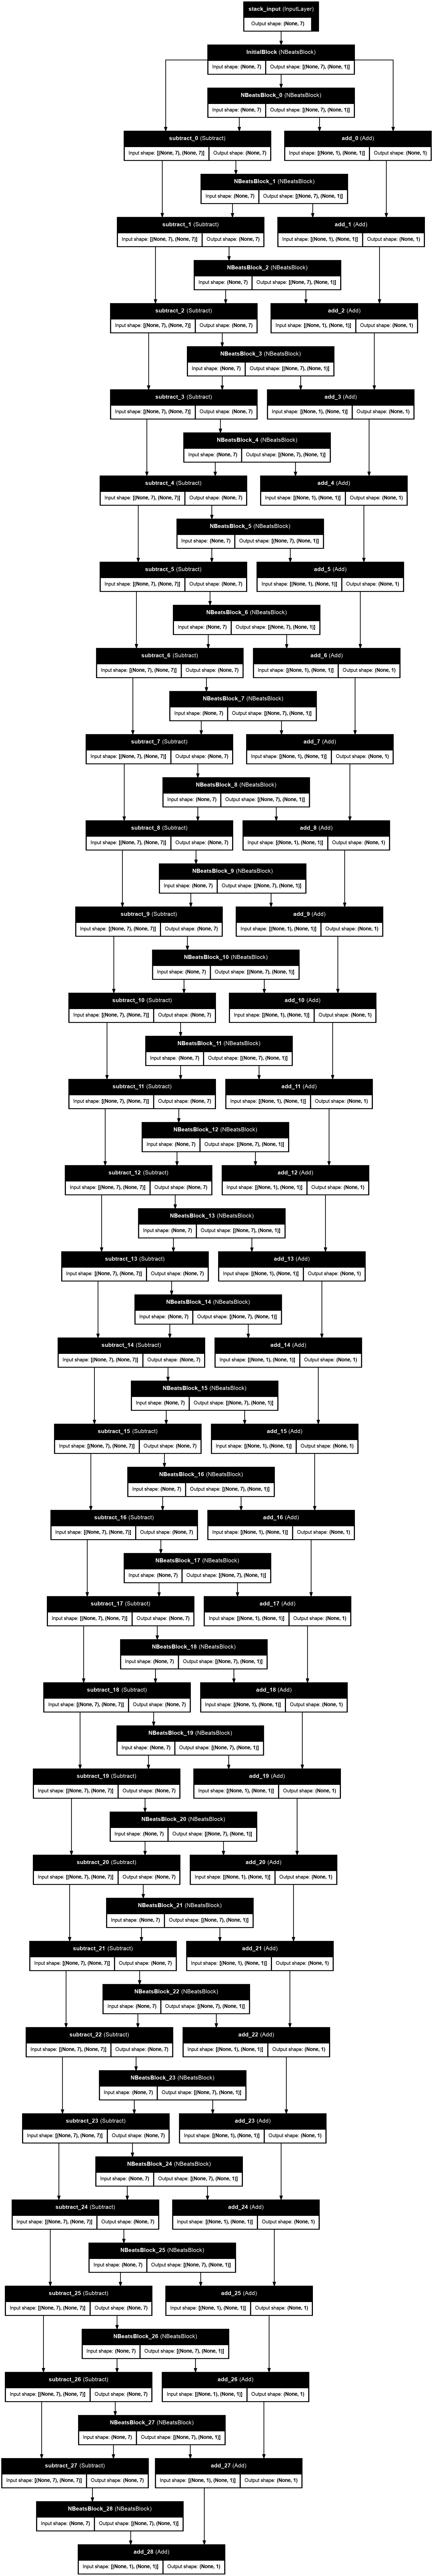

In [39]:
from tensorflow.keras.utils import plot_model
plot_model(loaded_model_7, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=96, rankdir='TB')


***-- CONTD IN NEXT NOTEBOOK --***